In [1]:
import gym

#​​维度​​：3 维向量 [cos(θ), sin(θ), θ_dot]
#cos(θ): 摆杆末端 x 坐标（范围 [-1, 1]）
#sin(θ): 摆杆末端 y 坐标（范围 [-1, 1]）
#θ_dot: 角速度（范围 [-8, 8] 弧度/秒，顺时针为负，逆时针为正）


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.5041445 ,  0.8636193 ,  0.48565724], dtype=float32)

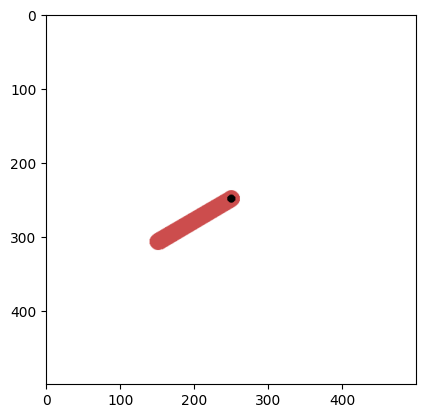

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch


#定义模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_statu = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(), #输出[0,+∞)
        )

        self.fc_mu = torch.nn.Sequential(
            torch.nn.Linear(128, 1), #输出(−1,1)
            torch.nn.Tanh(),
        )

        self.fc_std = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Softplus(), #输出和为1，表示概率分布
        )

    def forward(self, state):
        state = self.fc_statu(state)

        mu = self.fc_mu(state) * 2.0 #×2表示力矩输出，限制范围(-2,2)
        std = self.fc_std(state) #影响后续概率分布，控制探索程度
        return mu, std


model = Model()

model_td = torch.nn.Sequential( #表示状态价值
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

model(torch.randn(2, 3)), model_td(torch.randn(2, 3)) 

((tensor([[-1.3099],
          [ 0.3086]], grad_fn=<MulBackward0>),
  tensor([[0.7913],
          [0.6776]], grad_fn=<SoftplusBackward0>)),
 tensor([[0.3422],
         [0.1475]], grad_fn=<AddmmBackward0>))

In [4]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    #[1, 3] -> [1, 2]
    mu,std = model(state)

    #选择动作
    #创建一个正态分布对象，mu：分布的均值（期望值）std：分布的标准差（控制数据离散程度）
    #再从该正态分布中​​随机采样一个值
    action = torch.distributions.Normal(mu, std).sample().item()

    return action


get_action([1,0,0])

1.556563138961792

In [5]:
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state) #随机动作：env.action_space.sample()

        #执行动作,得到反馈 
        next_state, reward, over, _ = env.step([action]) #注意离散动作空间和连续动作空间，对action的格式输入有不同要求

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        #更新游戏状态,开始下一个动作
        state = next_state

    #[b, 3]
    states = torch.FloatTensor(states).reshape(-1, 3)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.FloatTensor(actions).reshape(-1, 1) #改了LongTensor到FloatTensor，使用LongTensor会导致后续概率计算报错，因为正态分布期望输入是浮点张量。
    #[b, 3]
    next_states = torch.FloatTensor(next_states).reshape(-1, 3)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()

/home/yuchen/Fdisk/miniconda3/envs/RL-py39/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_23796/3690952742.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).reshape(-1, 3)


(tensor([[ 9.5651e-01, -2.9171e-01, -4.3519e-01],
         [ 9.4555e-01, -3.2547e-01, -7.1002e-01],
         [ 9.3080e-01, -3.6553e-01, -8.5393e-01],
         [ 9.0889e-01, -4.1704e-01, -1.1196e+00],
         [ 8.8182e-01, -4.7160e-01, -1.2183e+00],
         [ 8.4589e-01, -5.3336e-01, -1.4293e+00],
         [ 7.9774e-01, -6.0300e-01, -1.6939e+00],
         [ 7.2818e-01, -6.8539e-01, -2.1575e+00],
         [ 6.3125e-01, -7.7558e-01, -2.6500e+00],
         [ 4.9992e-01, -8.6607e-01, -3.1930e+00],
         [ 3.2230e-01, -9.4664e-01, -3.9070e+00],
         [ 9.7053e-02, -9.9528e-01, -4.6191e+00],
         [-1.7470e-01, -9.8462e-01, -5.4562e+00],
         [-4.6839e-01, -8.8352e-01, -6.2373e+00],
         [-7.4616e-01, -6.6577e-01, -7.0960e+00],
         [-9.4482e-01, -3.2759e-01, -7.8954e+00],
         [-9.9781e-01,  6.6197e-02, -8.0000e+00],
         [-8.9326e-01,  4.4954e-01, -8.0000e+00],
         [-6.5487e-01,  7.5574e-01, -7.8108e+00],
         [-3.3748e-01,  9.4133e-01, -7.3955e+00],


In [6]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action]) 
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1265.7048549778344

In [7]:
#优势函数
def get_advantages(deltas): #​​delta​​：当前时间步的TD误差
    advantages = []

    #反向遍历deltas
    s = 0.0 
    for delta in deltas[::-1]: #从轨迹的最后一个时间步开始向前处理，确保计算A_t时A_t+1已经存在
        s = 0.9 * 0.9 * s + delta #折扣因子（γ）​​和​​GAE参数（λ）
                                  #前者控制未来奖励的重要性衰减速率。γ越接近0，模型越关注即时奖励；γ越接近1，模型越关注长期累积奖励
                                  #后者调节多步回报（Multi-step Returns）的权重衰减速率，平衡偏差（Bias）与方差（Variance）。λ=0时退化为单步时序差分（TD），λ=1时退化为蒙特卡洛（MC）估计
        advantages.append(s)

    #逆序
    advantages.reverse() #反转后为A0,A1,A2顺序
    return advantages


get_advantages(range(5))


[5.43839184, 6.7140640000000005, 7.0544, 6.24, 4.0]

In [8]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #改了学习率
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=5e-3)
    loss_fn = torch.nn.MSELoss() #用于量化预测值与目标值的差异

    #玩N局游戏,每局游戏训练M次
    for epoch in range(3000):
        #玩一局游戏,得到数据
        #states -> [b, 3]
        #rewards -> [b, 1]
        #actions -> [b, 1]
        #next_states -> [b, 3]
        #overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        #偏移reward,便于训练
        rewards = (rewards + 8) / 8 #改了reward，通过平移和缩放操作将原始奖励整体向上平移和将平移后的奖励压缩到更小区间

        #计算values和targets
        #[b, 3] -> [b, 1]
        values = model_td(states)

        #[b, 3] -> [b, 1]
        targets = model_td(next_states).detach() #.detach() 防止梯度传播，targets仅作为监督信号无需计算梯度
        targets = targets * 0.98 # 下一步动作折扣未来奖励
        targets *= (1 - overs)
        targets += rewards

        #计算优势,这里的advantages有点像是策略梯度里的reward_sum
        #只是这里计算的不是reward,而是target和value的差
        #[b, 1]
        deltas = (targets - values).squeeze(dim=1).tolist() #squeeze操作移除维度1，将形状压缩为 [batch_size]。​例如​​：[[0.8], [1.2]] → [0.8, 1.2]，便于后续逐元素处理
        advantages = get_advantages(deltas)
        advantages = torch.FloatTensor(advantages).reshape(-1, 1)

        #取出每一步动作的概率 
        #[b, 3] -> [b, 1],[b, 1]
        mu, std = model(states)
        #[b, 1]
        old_probs = torch.distributions.Normal(mu, std) #构建连续动作的概率分布对象​​
        old_probs = old_probs.log_prob(actions).exp().detach()
            #​​.log_prob(actions)​​：计算给定动作 actions 在分布下的​​对数概率密度​​（log-PDF），形状 [b, action_dim]。
            #​.exp()​​：将对数概率密度转换为​​原始概率密度值​​（PDF）。
            #.detach()​​：​​分离梯度​​，将概率密度值固定为常量

        #每批数据反复训练10次
        for _ in range(10):
            #重新计算每一步动作的概率
            #[b, 3] -> [b, 2]
            new_mu,new_std = model(states)
            #[b, 2] -> [b, 1]
            new_probs = torch.distributions.Normal(new_mu, new_std)
            new_probs = new_probs.log_prob(actions).exp()

            #求出概率的变化
            #[b, 1] - [b, 1] -> [b, 1]
            ratios = new_probs / old_probs

            #计算截断的和不截断的两份loss,取其中小的
            #[b, 1] * [b, 1] -> [b, 1]
            surr1 = ratios * advantages
            #[b, 1] * [b, 1] -> [b, 1]
            surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages

            loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            #重新计算value,并计算时序差分loss
            values = model_td(states)
            loss_td = loss_fn(values, targets)

            #更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            optimizer_td.zero_grad()
            loss_td.backward()
            optimizer_td.step()

        if epoch % 200 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()

0 -1299.5499110015944
200 -1102.9740237419915
400 -1171.1031870743045
600 -1116.498576578913
800 -1020.6041662436664
1000 -982.7213089345884
1200 -896.4401434895575
1400 -1142.7577467043764
1600 -892.4209731623399
1800 -761.5263983531861
2000 -802.0848633290935
2200 -563.953188334889
2400 -695.6598008390527
2600 -557.5343258169416
2800 -716.4087504847488


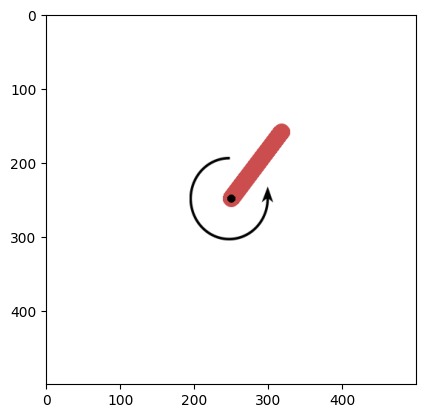

-404.56920810295026

In [12]:
test(play=True)